# Tutorial: Coarse-grained causal graph reconstruction

The algorithm implemented in the 'CausalGraph' class employes the Differentiable Information Imbalance (DII) to construct a coarse-grained causal graph from time series data. 

This notebook shows a tutorial of the methods implemented in this class. For more information, please refer to the causal_graph module in the DADApy documentation: https://dadapy.readthedocs.io/en/latest/modules.html

In [1]:
import numpy as np
import networkx as nx
from dadapy import CausalGraph
import matplotlib.pyplot as plt
import jax
import os
import time

jax.config.update('jax_platform_name', 'gpu') # can run on 'cpu' or 'gpu'; restart the
                                              # notebook kernel to make this change effective
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = 'false' # avoid jax memory preallocation

In [2]:
%load_ext autoreload
%autoreload 2

Given a set of $D$ dynamical variables $\{ x_\alpha(t)\}_{\alpha = 1}^D$, the algorithm aims at splitting the dynamical variables in groups with different levels of autonomy. We call $\mathcal{A} = \{x_\beta\}$ an autonomous subset if each (direct or indirect) cause of any variable $x_\beta \in \mathcal{A}$ also belongs to $\mathcal{A}$.

In the first step of the algorithm, $\forall \alpha=1,...,D$ we minimize the Differentiable Information Imbalance
\begin{equation}
    \Delta(\boldsymbol{w}\odot \boldsymbol{x}(t=0) \rightarrow x_\alpha(t=\tau))\,.
\end{equation}
Here, $\boldsymbol{w}$ is a vector of $D$ parameters weighting each dynamical variable, and $\odot$ denotes the element-wise product. The test is repeated by scanning several values of $\tau$, as the information transfer from two variables could appear at different time scales.

This first part of the algorithm is carried out by the method CausalGraph.optimize_present_to_future, which outputs the final weights for each optimization and the corresponding DII over all the training epochs.
In this tutorial, the input file contains a 9-dimensional trajectory of three Rossler systems $X$, $Y$ and $Z$ (columns 0:3, 3:6, 6:9), such that $X$ causes $Z$ and $Y$ causes $Z$ ($X$ and $Y$ are autonomous).

In [3]:
traj = np.load('./datasets/three_rossler_systems.npy')
print(traj.shape)

nvars = traj.shape[1]

(205001, 9)


We first initialize an object of the CausalGraph class and verify that the chosen number of samples is adequate to the length and memory of the process, namely that closest nearest neighbors in the distance space are not close in time. This step can be done automatically with the method return_nn_indices, which outputs the sequence of nearest neighbor indices of the sampled points (nn_indices[i] = j if j is the 1st neighbour of i). If the samples are not well spaced, the closest neighbor of i is typically the point with index i+1 or i-1, which can be visualized as a linear correlation in the plot indices vs nn_indices. If the scatter plot is more homogenous (ideally with zero correlation) the subsampling can be considered adequate for the following analysis.

2024-09-20 14:28:57.146417: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


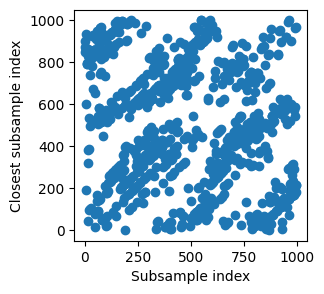

In [4]:
num_samples = 1000
time_lags = [10,30,50,70] # tested time lags between present and future
embedding_dim = 1         # length of time-delay embeddings of each variable (if 1, no embeddings are employed)
embedding_time = 1        # time lag between consecutive elements in time-delay embeddings

g = CausalGraph(time_series=traj, seed=0) # object of the class CausalGraph

nn_indices = g.return_nn_indices(
    variables=np.arange(nvars), # variables used to construct distance matrix 
    num_samples=num_samples,
    time_lags=time_lags,
    embedding_dim=embedding_dim,
    embedding_time=embedding_time,
    discard_close_ind=None,
)

plt.figure(figsize=(3,3))
plt.scatter(np.arange(num_samples), nn_indices)
plt.xlabel("Subsample index")
plt.ylabel("Closest subsample index")
plt.show()

Then, we run the optimization of the DII over all the target variables and all the chosen time lags:

In [5]:
weights_final, imbs_training, imbs_final, errors_final = (
    g.optimize_present_to_future(
        num_samples=num_samples,
        time_lags=time_lags,
        target_variables="all",
        embedding_dim=embedding_dim,
        embedding_time=embedding_time,
        num_epochs=1000,
        batches_per_epoch=1,
        l1_strength=0.,
        point_adapt_lambda=True,
        k_init=1,
        k_final=1,
        lambda_init=None,
        lambda_final=None,
        init_params=None,
        optimizer_name="adam",
        learning_rate=1e-2,
        learning_rate_decay="cos",
        compute_error=False,
        ratio_rows_columns=1,
        num_points_rows=None,
        discard_close_ind=None
    )
)

Training (target_var=0, tau=10):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=0, tau=30):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=0, tau=50):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=0, tau=70):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=1, tau=10):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=1, tau=30):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=1, tau=50):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=1, tau=70):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=2, tau=10):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=2, tau=30):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=2, tau=50):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=2, tau=70):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=3, tau=10):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=3, tau=30):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=3, tau=50):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=3, tau=70):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=4, tau=10):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=4, tau=30):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=4, tau=50):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=4, tau=70):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=5, tau=10):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=5, tau=30):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=5, tau=50):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=5, tau=70):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=6, tau=10):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=6, tau=30):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=6, tau=50):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=6, tau=70):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=7, tau=10):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=7, tau=30):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=7, tau=50):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=7, tau=70):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=8, tau=10):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=8, tau=30):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=8, tau=50):   0%|          | 0/1000 [00:00<?, ?it/s]

Training (target_var=8, tau=70):   0%|          | 0/1000 [00:00<?, ?it/s]

Plot the DII during the training for all target variables and all tested time lags, together with the optimized final weights

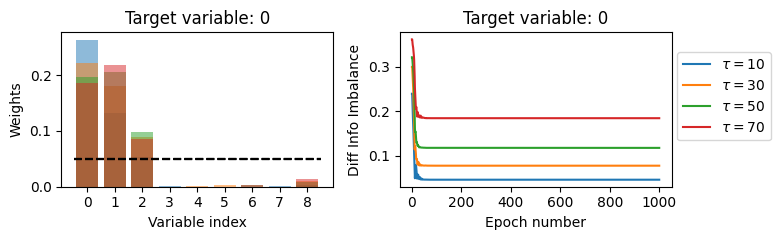

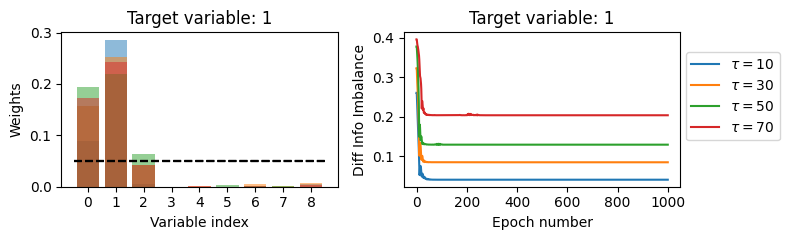

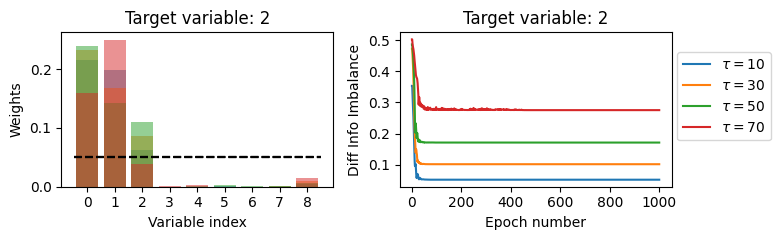

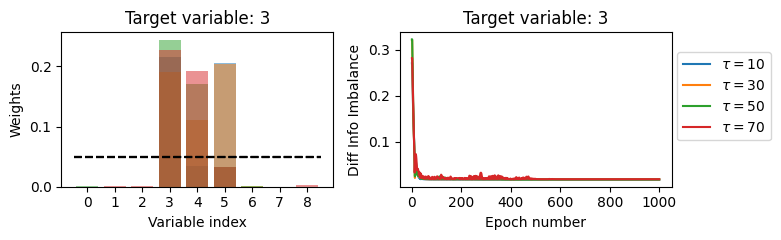

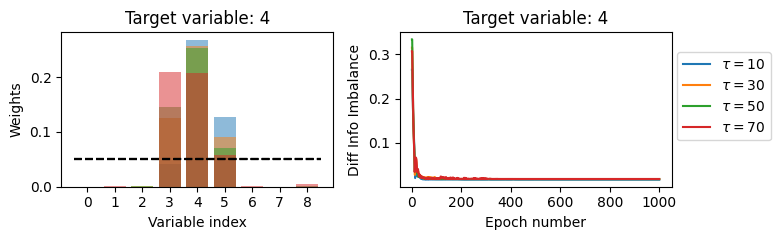

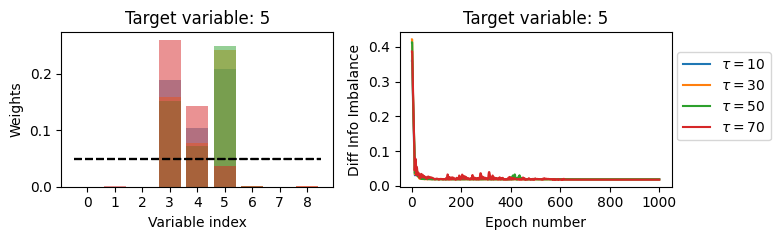

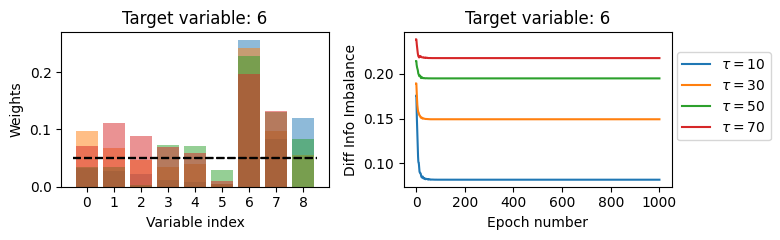

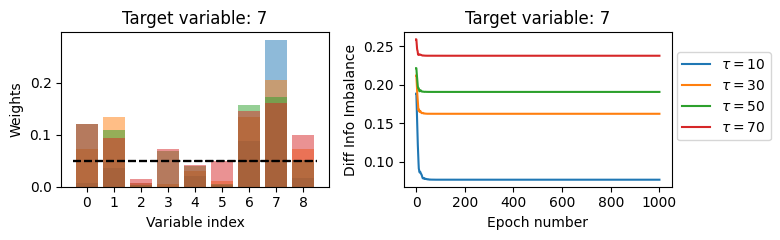

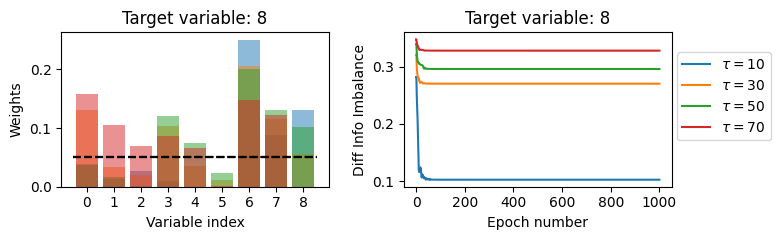

In [6]:
threshold = 0.05 # visualize threshold used in the next step of the algorithm

for ivar in range(nvars):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,2.5))
    for jtau, tau in enumerate(time_lags):
        ax1.bar(np.arange(nvars), weights_final[ivar,jtau], label=f"$\\tau = {tau}$", alpha=0.5)
        ax1.hlines(threshold, -0.5, nvars-1+0.5, linestyle="--", color="black")
        ax1.set(xlabel="Variable index", ylabel="Weights", title=f"Target variable: {ivar}")

        ax2.plot(imbs_training[ivar, jtau], label=f"$\\tau = {tau}$")
        ax2.set(xlabel="Epoch number", ylabel="Diff Info Imbalance", title=f"Target variable: {ivar}")

    ax2.legend(loc=(1.02,0.3))
    ax1.set_xticks(np.arange(nvars))
    fig.tight_layout()
    fig.show()

In the next step of the pipeline, an adjacency matrix defining a directed graph is constructed. Each node represents a dynamical variable and a link $x_\alpha \rightarrow x_\beta$ is interpreted as the presence of a direct or indirect (i.e. mediated by other variables) link between variables $x_\alpha$ and $x_\beta$, at some unspecified time lag $\tau$. Importantly, not all the indirect links are explicitely represented in this graph, as $x_\alpha$ and $x_\beta$ could be linked either if a link $x_\alpha\rightarrow x_\beta$ is present or if the two variables are linked by an oriented path $x_\alpha\rightarrow...\rightarrow x_\beta$.

To construct the adjacency matrix, for each pair $x_\alpha \rightarrow x_\beta$ only the maximum weight found over all the tested time lags is retained. If such a weight is larger than the chosen threshold, the corresponding entry of the adjacency is set to 1, otherwise it is set to 0.
If the weight $w_\beta$ is found to be different from zero for at least a value of $\tau$ (for the moment we use an arbitrary threshold to check if $w_\beta > 0$), then a link $x_{\beta} \rightarrow x_{\alpha}$ is constructed.

In [7]:
adj_matrix = g.compute_adj_matrix(weights=weights_final, threshold=threshold)
print(adj_matrix)

[[1. 1. 1. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 0. 1.]
 [0. 0. 0. 1. 1. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]]


Finally, the above adjacency matrix is employed to identify the groups of the coarse-grained causal graph and their level of "autonomy".

The scheme of the algorithm is the following:

    1. for each node (dynamical variable), all the ancestors are identified by following backward the arrows of the graph. By definition, the ancestors of a variable is the minimal autonomous subset to which it belongs.

    2. the following steps are iterated over an integer variable 'order', which defines the step of the algorithm at which a group becomes autonomous, namely its 'level of autonomy'. The steps are repeated until all the variables have been assigned to a group.

        2.1. Take the smallest set of minimal autonomous subset available at the current step. This set is necessairly an autonomous group at the current step.

        2.2. Find all the minimal autonomous subsets which have empty intersection with the autonomous group identified at step 2.1. All these sets define other autonomous groups with the same level of autonomy

        2.3 Delete from the remaining minimal autonomous subsets all the variables that have been assigned to an autonomous group, and iterate.

The output of the algorithm, implemented in the method CausalGraph.find_groups, is a dictionary with pairs (group_id, order) as keys and lists containing the indices of the variables in each group as values. group_id is an integer number identifying the group, while order is an integer identifying the step of the algorithm at which the group is identified, namely its level of autonomy. Both group_id and order start from 0.

In [8]:
groups_dictionary = g.find_groups(adj_matrix=adj_matrix)
print(groups_dictionary)

{(0, 0): [0, 1, 2], (1, 0): [3, 4, 5], (2, 1): [6, 7, 8]}


Finally, the groups identified at the previous step can be represented as single nodes in a coarse-grained graph, where a link is drawn only between groups $G_\alpha$ and $G_\beta$ identified at consecutive orders if at least a variable in $G_\alpha$ is linked to a variable in $G_\beta$ in the original microscopic graph. In this graph, a direct causal effect between two groups can only be inferred from direct links, while the link between two groups which are indirectly linked through an oriented path may be either direct or indirect. The following method draws the coarse-grained graph and returns an object of the networkx.DiGraph class.

Group A (3 variables, order 0): (0, 1, 2)
Group B (3 variables, order 0): (3, 4, 5)
Group C (3 variables, order 1): (6, 7, 8)


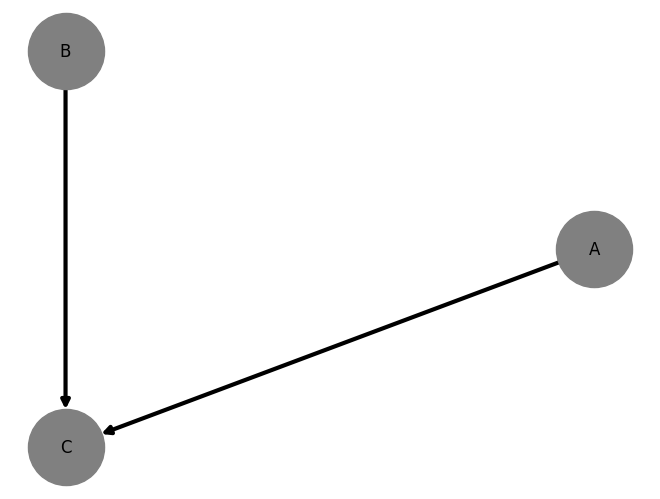

In [10]:
G = g.community_graph_visualization(groups_dictionary=groups_dictionary,
                                adj_matrix=adj_matrix)